In [1]:
using NBInclude
using LinearAlgebra

@nbinclude("julia_function.ipynb")

allskyts2 (generic function with 1 method)

In [140]:
function c(u, du, dr)
    e = 10^u
    effarea(e) * 10000 * flx(e) * du * dr * 10^u * log(10) * 3
end

function o(dm2, u, r, dr, l, b, θ)
    e = 10^u
    oscprob(e, dm2, r) * sbinarea.((r+dr), l, b, θ)
end


function perfectedistapprox(dm2, l, b, θ, nsteps)
    
    function f(u)
        et = 10 ^ u
        rbins = range(0, 30, nsteps)
        dr = rbins[2] - rbins[1]

        vols = dr .* sbinarea.((rbins .+ dr), l, b, θ) .* oscprob.(et, dm2, rbins)

        flux = flx(et) .* probdens.(cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b)) * 3
        effa = effarea(et)*10000

        sum(.*(flux, vols, effa))
    end

    # du = (log10(emax) - log10(emin)) / nsteps
    us = range(log10(emin), log10(emax), nsteps)

    du = us[2] - us[1]

    output = f.(us) .* du .* (10 .^ us) .* log(10)
end

perfectedistapprox (generic function with 1 method)

In [309]:
function matrixA(dm2, l, b, bins)  

    us = range(log10(emin), log10(emax), bins)

    rs = range(0, 30, bins)

    du = us[2] - us[1]
    dr = rs[2] - rs[1]

    A = [c(u, du, dr)*o(dm2, u, r, dr, l, b, 0.005) for u in us, r in rs]

end

function matrixOsc(dm2, bins)

    us = range(log10(emin), log10(emax), bins)
    es = 10 .^ us
    rs = range(0, 30, bins)
    # dr = rs[2] - rs[1]

    O = [oscprob(e, dm2, r) for e in es, r in rs]
end

matrixOsc (generic function with 1 method)

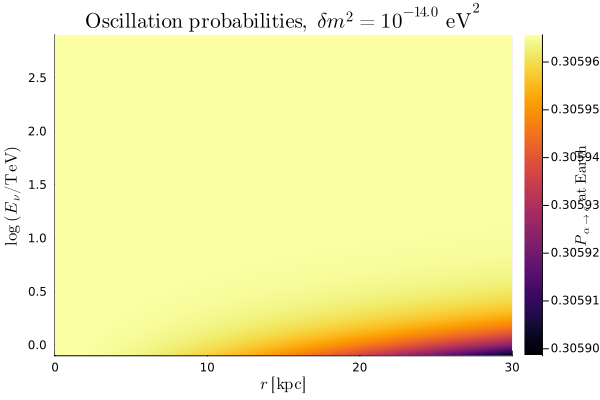

In [349]:
# Oscillation probabilities

us = range(log10(emin), log10(emax), 1000)
rs = range(0, 30, 1000)

O = matrixOsc(10^(-17), 1000)

heatmap(
    rs,
    us,
    O,
    title=L"\mathrm{Oscillation~probabilities},~\delta m^2 = 10^{-14.0}~\mathrm{eV}^2",
    xlabel=L"r~[\mathrm{kpc}]",
    ylabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    colorbar_title=L"P_{\alpha \to e}~\mathrm{at~Earth}"
)

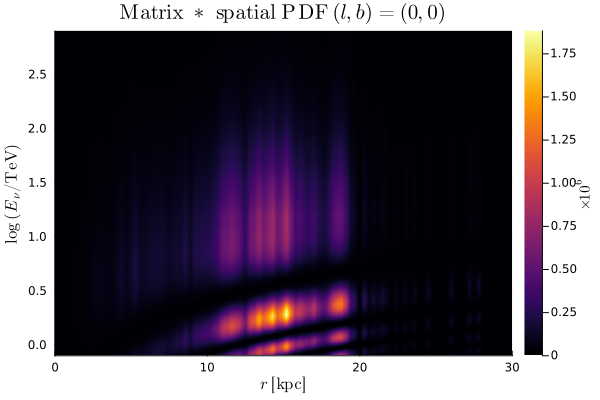

In [241]:
# Visualizing the full matrix

nbins = 1000
dm2 = 10^(-14)

us = range(log10(emin), log10(emax), nbins)

rs = range(0, 30, nbins)

A = matrixA(dm2, 0, 0, nbins)

for j in 1:nbins
    for i in 1:nbins
        A[i, j] *= probdens(cartx(rs[j], 0, 0), carty(rs[j], 0, 0), cartz(rs[j], 0, 0))
    end
end

heatmap(
    rs,
    us,
    A .* 1000000,
    title=L"\mathrm{Matrix}~*~\mathrm{spatial~PDF}~(l, b) = (0, 0)",
    xlabel=L"r~[\mathrm{kpc}]",
    ylabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    colorbar_title=L"\times 10^6"
)

In [437]:
function matrixOsc1(dm2, bins)

    us = range(-4, 0, bins)
    es = 10 .^ us
    rs = range(0, 30, bins)

    O = [oscprob(e, dm2, r) for e in es, r in rs]
end

function justosc(dm2, bins)

    function cososc(dm2, e, r)
        convfactor = 3.086e19 * 5.06773093741 * 1e6
        r *= convfactor
        osc = (cos((dm2 * r)/(4*e*1e12)))^2
    end

    us = range(log10(emin), log10(emax), bins)
    es = 10 .^ us
    rs = range(0, 30, bins)
    dr = rs[2] - rs[1]

    justO = [cososc(dm2, e, r+dr) for e in es, r in rs]

end

    

function Odet(dm2, bins)
    d = abs(det(matrixOsc(dm2, bins)))

end

binss = 2:1:100

logdm2s = range(-14.0, -9.0, length=500)
dm2s = 10 .^ logdm2s

detOmat = [Odet(dm2, bins) for dm2 in dm2s, bins in binss]



500×99 Matrix{Float64}:
 0.0567219   0.00381338   4.40736e-5   …  0.0           0.0
 0.0252659   0.00520911   3.95511e-5      0.0           0.0
 0.0034097   0.00623173   3.15328e-5      0.0           0.0
 0.0026392   0.00652908   2.1643e-5       0.0           0.0
 0.0247249   0.00593151   1.20645e-5      0.0           0.0
 0.0591656   0.00456716   4.75201e-6   …  0.0           0.0
 0.0872401   0.00285112   6.45661e-7      0.0           0.0
 0.091923    0.00131729   6.54846e-7      0.0           0.0
 0.0688298   0.000355694  4.7266e-7       0.0           0.0
 0.0311124   9.05791e-6   9.57339e-8      0.0           0.0
 0.00327799  6.46587e-6   3.45953e-11  …  0.0           0.0
 0.00553356  1.11363e-5   1.72363e-9      0.0           0.0
 0.0380846   2.74485e-5   2.48619e-7      0.0           0.0
 ⋮                                     ⋱                
 0.0471461   0.0134711    0.00163762      5.23426e-110  4.17549e-82
 0.0504076   0.00217572   0.000160915     5.13833e-122  1.0137e-87
 0.0

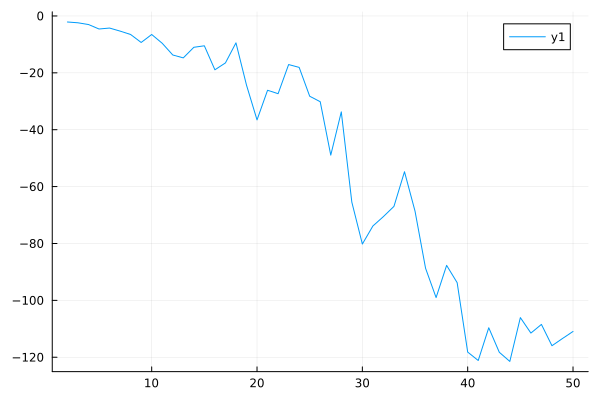

In [449]:
bns = 2:1:50
plot(
    bns,
    log10.(Odet.(10^(-12), bns))
)

In [440]:
heatmap(
    binss,
    logdm2s,
    log10.(detOmat),
    title=L"\log~|\det~(O)|",
    xlabel=L"\mathrm{number~of~bins}",
    ylabel=L"\log (\delta m^2)",
    color=:inferno
)
savefig("detO_plot.png")

"/Users/millermacdonald/Desktop/Research_shit/Summer_2023_Research/GC_calcs/detO_plot.png"

In [171]:
function pdreconstruct(dm2, l, b, bins)

    mat = matrixA(dm2, l, b, bins)

    eventsvec = perfectedistapprox(dm2, l, b, 0.005, bins)

    sol = pinv(mat) * eventsvec

    # sol = mat \ eventsvec

end

function pdtrue(dm2, l, b, bins)

    rbins = range(0, 30, bins)

    pds = probdens.(cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b))

end


pdtrue (generic function with 1 method)

In [218]:
function recoaccuracy(dm2, bins, l, b)

    truepd = pdtrue(dm2, l, b, bins)

    recpd = pdreconstruct(dm2, l, b, bins)

    # acc = norm((recpd .- truepd) ./ truepd)
    accvec = norm(recpd .- truepd) / norm(truepd)

end

recoaccuracy (generic function with 1 method)

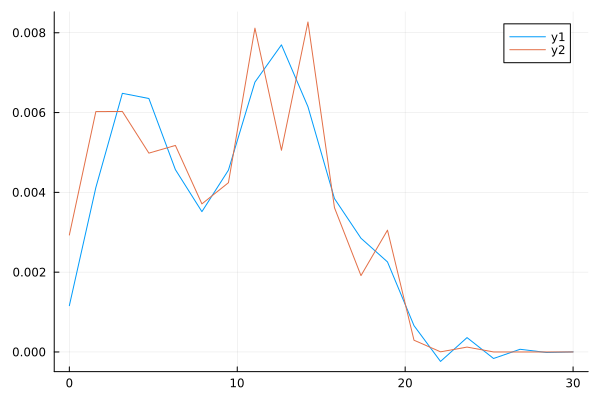

In [220]:
nbins = 20

rbins = range(0, 30, nbins)

plot(
    rbins,
    [pdreconstruct(10^(-14), 0, 0, nbins) pdtrue(10^(-14), 0, 0, nbins)]
)


In [267]:
# Plotting accuracies

ls = -π:0.1:π
bs = (-π/2):0.1:(π/2)

testmat = [recoaccuracy(10^(-10), 50, l, b) for b in bs, l in ls]

32×63 Matrix{Float64}:
 1.0       1.0       1.0       1.0       …  1.0       1.0       1.0
 0.968583  0.968807  0.96905   0.969306     0.968928  0.968786  0.968665
 0.967232  0.967775  0.968278  0.968749     0.967882  0.967676  0.967446
 0.970424  0.970877  0.971291  0.971684     0.970837  0.970712  0.970567
 0.973401  0.973651  0.97388   0.974108     0.973504  0.97348   0.973447
 0.97566   0.975719  0.975773  0.975841  …  0.975587  0.97562   0.975648
 0.976692  0.976685  0.976676  0.976673     0.976663  0.976676  0.976687
 0.976017  0.975489  0.975122  0.975092     0.97615   0.976098  0.976048
 0.97121   0.970872  0.970687  0.970818     0.969667  0.970283  0.9708
 0.960163  0.962778  0.965336  0.967732     0.957228  0.958639  0.959537
 0.945762  0.95336   0.960334  0.966324  …  0.942992  0.944757  0.945649
 0.923757  0.932049  0.93954   0.944189     0.92578   0.926445  0.925274
 0.888315  0.889311  0.887615  0.883757     0.888185  0.88716   0.887526
 ⋮                                 

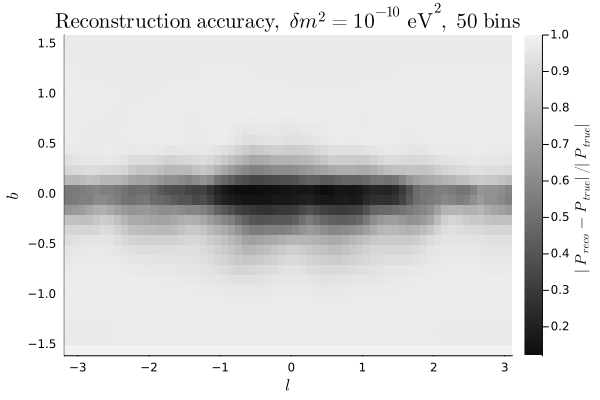

In [270]:
heatmap(
    ls,
    bs,
    testmat,
    c=:grays,
    colorbar_title=L"|P_{reco} - P_{true}| / |P_{true}|",
    title=L"\mathrm{Reconstruction~accuracy},~\delta m^2 = 10^{-10}~\mathrm{eV}^2,~50~\mathrm{bins}",
    xlabel=L"l",
    ylabel=L"b"
)


In [603]:
function perfectedist(dm2, l, b, θ, nbins)
    
    function f(u)
        et = 10 ^ u
        rbins = range(0, 30, nsteps)
        dr = rbins[2] - rbins[1]

        vols = dr .* sbinarea.((rbins .+ dr), l, b, θ) .* oscprob.(et, dm2, rbins)

        flux = flx(et) .* probdens.(cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b)) * 3
        effa = effarea(et)*10000

        sum(.*(flux, vols, effa))
    end

    nsteps = 1000

    stepsperbin = convert(Int, nsteps/nbins)

    us = range(log10(emin), log10(emax), nsteps)
    du = us[2] - us[1]
    steps = f.(us) .* du .* (10 .^ us) .* log(10)

    mat = reshape(steps, (stepsperbin, :))

    sums = sum(mat, dims=1)
    νbins = vec(sums)
end

function pdreconstruct1(dm2, l, b, bins)

    mat = matrixA(dm2, l, b, bins)

    eventsvec = perfectedist(dm2, l, b, 0.005, bins)

    sol = pinv(mat) * eventsvec

    # sol = mat \ eventsvec

end

pdreconstruct1 (generic function with 1 method)

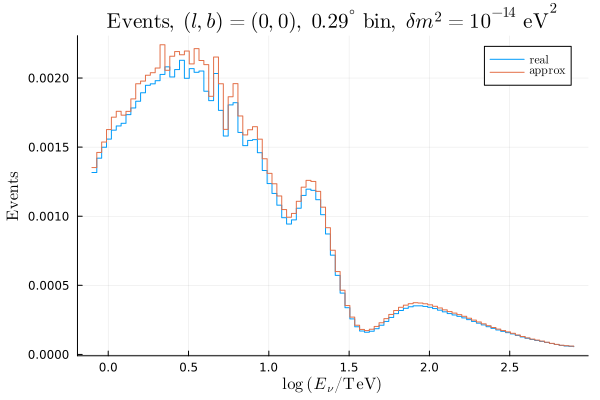

In [667]:
ebinnum = 100

ebins = range(log10(emin), log10(emax), ebinnum)

real = perfectedist(10^(-13), 0, 0, 0.005, ebinnum)
approx = perfectedistapprox(10^(-13), 0, 0, 0.005, ebinnum)

plot(
    ebins,
    [real approx],
    seriestype=:step,
    title=L"\mathrm{Events},~(l, b) = (0, 0),~0.29^{\circ}~\mathrm{bin},~\delta m^2 = 10^{-14}~\mathrm{eV}^2",
    label=[L"\mathrm{real}" L"\mathrm{approx}"],
    xlabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    ylabel=L"\mathrm{Events}"
)

In [375]:
solapprox = pdreconstruct(10^(-14), 0, 0, 50)

plot(
    range(0, 30, 50),
    solapprox,
    xlabel=L"\mathrm{r}~[\mathrm{kpc}]",
    ylabel=L"P_{\nu}~[\mathrm{m}^{-3}]",
    label=false,
    title=L"P_{\nu,~reco}~\mathrm{with~fully~integrated~events~as~input}"
)

norm((matrixA(10^(-14), 0, 0, 50) * solapprox) - perfectedist(10^(-14), 0, 0, 0.005, 50))

0.002482870356625758

In [459]:
function testcos(c, bins)
    xs = range(1, 100, bins)
    ys = range(1, 100, bins)

    mat = [cos(c * x/y) for y in ys, x in xs]

    detmat = abs(det(mat))
    
end

binss = 2:1:100
cs = 10:1:1000

testdetmat = [testcos(c, bins) for c in cs, bins in binss]

heatmap(
    binss,
    cs,
    log10.(testdetmat),
    xlabel=L"\mathrm{number~of~bins}",
    ylabel=L"c",
    title=L"\log~|\det~(\Delta)|" 
)
savefig("detDelta_plot_expanded.png")

"/Users/millermacdonald/Desktop/Research_shit/Summer_2023_Research/GC_calcs/detDelta_plot_expanded.png"

In [680]:
function pdreconstructapprox(dm2, l, b, bins, ival)

    pdperfect = perfectedist(dm2, l, b, 0.005, bins)

    function approx1(solapprox)
        solapprx = vec(solapprox)
        A = matrixA(dm2, l, b, bins)
        # multiply = norm([sum(A[j,:][i] * solapprox[i] for i in 1:bins) for j in 1:bins])
        output = norm((matrixA(dm2, l, b, bins) * solapprx) - pdperfect)
        # output = multiply .- pdperfect
    end
    
    x0 = zeros(1, bins) .+ ival
    # x0 = reshape(pdtrue(dm2, l, b, bins), 1, bins)
    optim = optimize(approx1, x0)
    params = Optim.minimizer(optim)
    return vec(params)
end

pdreconstructapprox (generic function with 2 methods)

In [681]:
pdreconstructapprox(dm2, 0, 0, 20)

20-element Vector{Float64}:
  0.014923065001443116
  0.01637220017827862
  0.015600285141383527
  0.015579702139980816
  0.00915189466675318
  0.005332050469514116
  0.0011279756847505087
  0.001963632130600741
  0.0026305707560707625
  0.004778447596744425
  0.005889390667487392
  0.0017995846142727279
  0.0052874779525228935
 -0.005551394927357111
 -0.002632881734641739
  0.0014021233606573082
  0.0027044236533690373
 -0.002305900559327247
  0.0020523760759933473
 -0.0015191515127690905

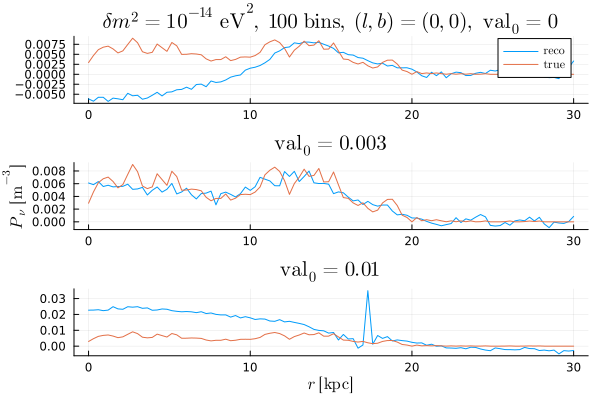

In [690]:
bins = 100; dm2 = 10^(-14.0)

rbins = range(0, 30, bins)

plot0 = plot(
    rbins,
    [pdreconstructapprox(dm2, 0, 0, bins, 0) pdtrue(dm2, 0, 0, bins)],
    # xlabel=L"r~[\mathrm{kpc}]",
    # ylabel=L"P_{\nu}~[\mathrm{m}^{-3}]",
    label=[L"\mathrm{reco}" L"\mathrm{true}"],
    title=L"\delta m^2 = 10^{-14}~\mathrm{eV}^2,~100~\mathrm{bins},~(l, b) = (0, 0),~\mathrm{val}_0 = 0"
)

plot1 = plot(
    rbins,
    [pdreconstructapprox(dm2, 0, 0, bins, 0.003) pdtrue(dm2, 0, 0, bins)],
    # xlabel=L"r~[\mathrm{kpc}]",
    ylabel=L"P_{\nu}~[\mathrm{m}^{-3}]",
    # label=[L"\mathrm{reco}" L"\mathrm{true}"],
    label=false,
    title=L"\mathrm{val}_0 = 0.003"
)

plot3 = plot(
    rbins,
    [pdreconstructapprox(dm2,0, 0, bins, 0.01) pdtrue(dm2, 0, 0, bins)],
    xlabel=L"r~[\mathrm{kpc}]",
    # ylabel=L"P_{\nu}~[\mathrm{m}^{-3}]",
    # label=[L"\mathrm{reco}" L"\mathrm{true}"],
    label=false,
    title=L"\mathrm{val}_0 = 0.01"
)

plot(plot0, plot1, plot3, layout=(3,1))

In [688]:
bins = 100; dm2 = 10^(-14)

ebins = range(log10(emin), log10(emax), bins)

recoedistapprox = matrixA(dm2, 0, 0, bins) * pdreconstructapprox(dm2, 0, 0, bins, 0.0)
recoedist = matrixA(dm2, 0, 0, bins) * pdreconstruct(dm2, 0, 0, bins)



100-element Vector{Float64}:
 0.0014169608765082378
 0.0015292695405867314
 0.0015492914720400914
 0.0015691645275744076
 0.001601135986072059
 0.0015923954355122553
 0.0015449383156383122
 0.0015529597235821781
 0.0017057269193747995
 0.0019592259923521
 0.0022545339418875835
 0.002554112700884765
 0.0027342561609850213
 ⋮
 0.00013274606229148433
 0.0001219089869031129
 0.0001130227145394801
 0.00010511175962307698
 9.785989953742582e-5
 8.933997008076254e-5
 8.090711183408248e-5
 7.33429430333781e-5
 6.689816866630008e-5
 6.368706707834787e-5
 6.0631471300970035e-5
 5.772370289281746e-5

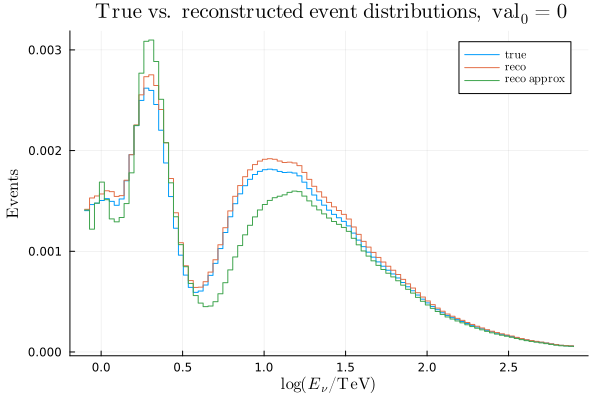

In [689]:
plot(
    ebins,
    [perfectedist(dm2, 0, 0, 0.005, bins) recoedist recoedistapprox],
    seriestype=:step,
    xlabel=L"\log (E_{\nu} / \mathrm{TeV})",
    ylabel=L"\mathrm{Events}",
    label=[L"\mathrm{true}" L"\mathrm{reco}" L"\mathrm{reco~approx}"],
    title=L"\mathrm{~True~vs.~reconstructed~event~distributions},~\mathrm{val}_0 = 0"
)

In [636]:
norm(recoedistapprox .- perfectedist(dm2, 0, 0, 0.005, bins))
# norm(recoedist .- perfectedist(dm2, 0, 0, 0.005, bins))

0.0020310053121023533

In [640]:
dm2 = 10^(-14)
binss = [5, 10, 20, 25, 40, 50, 100]

accs = [norm(matrixA(dm2, 0, 0, bins) * pdreconstruct(dm2, 0, 0, bins) .- perfectedist(dm2, 0, 0, 0.005, bins)) for bins in binss]
accsapprox = [norm(matrixA(dm2, 0, 0, bins) * pdreconstructapprox(dm2, 0, 0, bins) .- perfectedist(dm2, 0, 0, 0.005, bins)) for bins in binss]

7-element Vector{Float64}:
 0.000807796332461678
 0.00063630107261685
 0.000366518586170191
 0.0002741157722198364
 0.0006333419106558015
 0.000746894903382163
 0.0020310053121023533

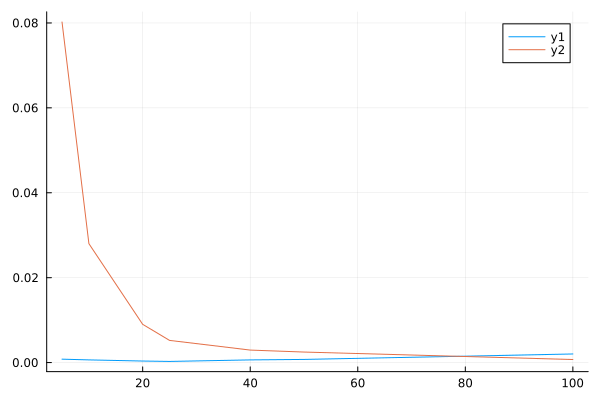

In [645]:
plot(
    binss,
    [accsapprox accs]
)